In [1]:
import matplotlib.pyplot as plt

In [2]:
# utils

import numpy as np
from collections import deque


class Grid:

    def __init__(self, xlim, ylim, pacman_effect=True, delay=5, max_steps=10_000):
        self.xlim = xlim
        self.ylim = ylim
        self.goal = None
        self.agent = None
        self.pacman_effect = pacman_effect
        self.delay = delay
        self.rewards_buffer = deque()
        for i in range(self.delay):
            self.rewards_buffer.append(0)  # reward for the initial steps in which no actual rewards are given
        if max_steps is not None:
            self.max_steps = max_steps
            self.steps = 0
        self.flag = False

    def reset(self, allow_start_goal=False):
        goal = [np.random.randint(self.xlim), np.random.randint(self.ylim)]
        if allow_start_goal:
            agent = [np.random.randint(self.xlim), np.random.randint(self.ylim)]
        else:
            agent = goal
            while agent == goal:
                agent = [np.random.randint(self.xlim), np.random.randint(self.ylim)]
        self.goal = goal
        self.agent = agent
        self.steps = 0
        self.rewards_buffer = deque()
        for i in range(self.delay):
            self.rewards_buffer.append(0)
        self.flag = False
        return tuple(self.get_agent())

    def get_agent(self):
        return self.agent.copy()

    def get_goal(self):
        return self.goal.copy()

    def get_action_space(self):
        return 5

    def get_max_steps(self):
        return self.max_steps

    def get_step(self):
        return self.steps

    def step(self, action):
        self.steps += 1
        if action == 0:  # LEFT
            self.agent[1] -= 1
            if self.pacman_effect:
                if self.agent[1] < 0:
                    self.agent[1] += self.ylim
            else:
                if self.agent[1] < 0:
                    self.agent[1] = 0
        elif action == 2:  # RIGHT
            self.agent[1] += 1
            if self.pacman_effect:
                if self.agent[1] >= self.ylim:
                    self.agent[1] -= self.ylim
            else:
                if self.agent[1] >= self.ylim:
                    self.agent[1] = self.ylim - 1
        elif action == 1:  # UP
            self.agent[0] -= 1
            if self.pacman_effect:
                if self.agent[0] < 0:
                    self.agent[0] += self.xlim
            else:
                if self.agent[0] < 0:
                    self.agent[0] = 0
        elif action == 3:  # DOWN
            self.agent[0] += 1
            if self.pacman_effect:
                if self.agent[0] >= self.xlim:
                    self.agent[0] -= self.xlim
            else:
                if self.agent[0] >= self.xlim:
                    self.agent[0] = self.xlim - 1
        elif action == 4:  # IDLE
            pass
        reward = 0
        if self.agent == self.goal:
            reward = 10
        self.rewards_buffer.append(reward)
        if self.steps >= self.max_steps:
            self.flag = True
        return tuple(self.get_agent()), self.rewards_buffer.popleft(), self.flag


In [4]:
# main

from tqdm import trange
import pickle


xdim = 5
ydim = 5
num_actions = 5
epsilon_0 = 3
learning_rate = 0.15
lamb = 0.9
gamma = 0.95
num_episodes = 1000
max_steps = 20_000

delays = [0,1,3,5,10,25,50,100]


for delay in delays:
    
    # Standard approach
    seed = 42
    np.random.seed(seed)
    env = Grid(xdim, ydim,delay=delay,max_steps=max_steps)

    storing_rewards = np.empty((num_episodes, env.get_max_steps()))
    for episode in trange(num_episodes):
        q = np.zeros((xdim, ydim, num_actions))
        for x in range(xdim):
            for y in range(ydim):
                q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
        traces = np.zeros((xdim, ydim, num_actions))

        state = env.reset()
        # eps-greedy action
        epsilon = epsilon_0
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action = np.random.randint(num_actions)
        else:
            action = np.argmax(q[state])
        #
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            storing_rewards[episode, env.get_step()-1] = reward
            # replacing trace
            traces[(*state, action)] = 1
            #
            # eps-greedy action
            epsilon = epsilon_0/(np.sqrt(env.get_step())+1) #decaying exploration 
            draw = np.random.uniform(0, 1)
            if draw < epsilon:
                action_next = np.random.randint(num_actions)
            else:
                action_next = np.argmax(q[state_next])
            #
            # update q
            q = q + traces*learning_rate*(reward + gamma*q[(*state_next, action_next)] - q[(*state, action)])
            #
            # replacing trace
            traces *= lamb*gamma
            #
            state = state_next
            action = action_next


    # DELAYED TRACES
    seed = 42
    np.random.seed(seed)
    env = Grid(xdim, ydim,delay=delay,max_steps=max_steps)
    
    del_storing_rewards = np.empty((num_episodes, env.get_max_steps()))
    for episode in trange(num_episodes):
        del_q = np.zeros((xdim, ydim, num_actions))
        for x in range(xdim):
            for y in range(ydim):
                del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
        del_traces = np.zeros((xdim, ydim, num_actions))

        state_buffer = deque()
        action_buffer = deque()
        state = env.reset()
        # eps-greedy action
        epsilon = epsilon_0
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action = np.random.randint(num_actions)
        else:
            action = np.argmax(del_q[state])
        #
        state_buffer.append(state)
        action_buffer.append(action)
        done = False
        while not done:
            state_next, reward, done = env.step(action)
            del_storing_rewards[episode, env.get_step()-1] = reward
            # eps-greedy action
            epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
            draw = np.random.uniform(0, 1)
            if draw < epsilon:
                action_next = np.random.randint(num_actions)
            else:
                action_next = np.argmax(del_q[state_next])
            #
            state_buffer.append(state_next)
            action_buffer.append(action_next)
            if env.get_step() > delay:
                state_delayed = state_buffer.popleft()
                action_delayed = action_buffer.popleft()
                state_next_delayed = state_buffer[0]
                action_next_delayed = action_buffer[0]
                # replacing trace
                del_traces[(*state_delayed, action_delayed)] = 1
                #
                # update q
                del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                              del_q[(*state_delayed, action_delayed)])
                #
                # replacing trace
                del_traces *= lamb*gamma
                #
            state = state_next
            action = action_next

    # Storing
    with open(f'pickles/rewards_d{delay}.pickle', 'wb') as door:
        pickle.dump(storing_rewards, door)
    with open(f'pickles/delayed_rewards_d{delay}.pickle', 'wb') as door2:
        pickle.dump(del_storing_rewards, door2)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:23<00:00,  4.90it/s]


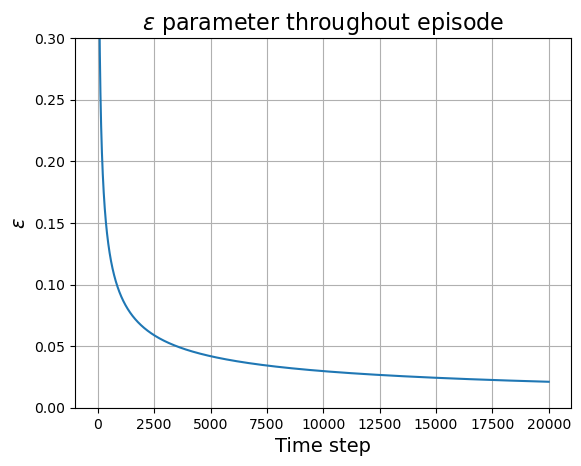

In [8]:
plt.plot(range(max_steps),[min(1,epsilon_0/(np.sqrt(i)+1)) for i in range(max_steps)])
plt.title("$\epsilon$ parameter throughout episode",fontsize=16)
plt.ylabel("$\epsilon$",fontsize=14)
plt.xlabel("Time step",fontsize=14)
plt.grid()
plt.ylim([0,0.3])
plt.show()

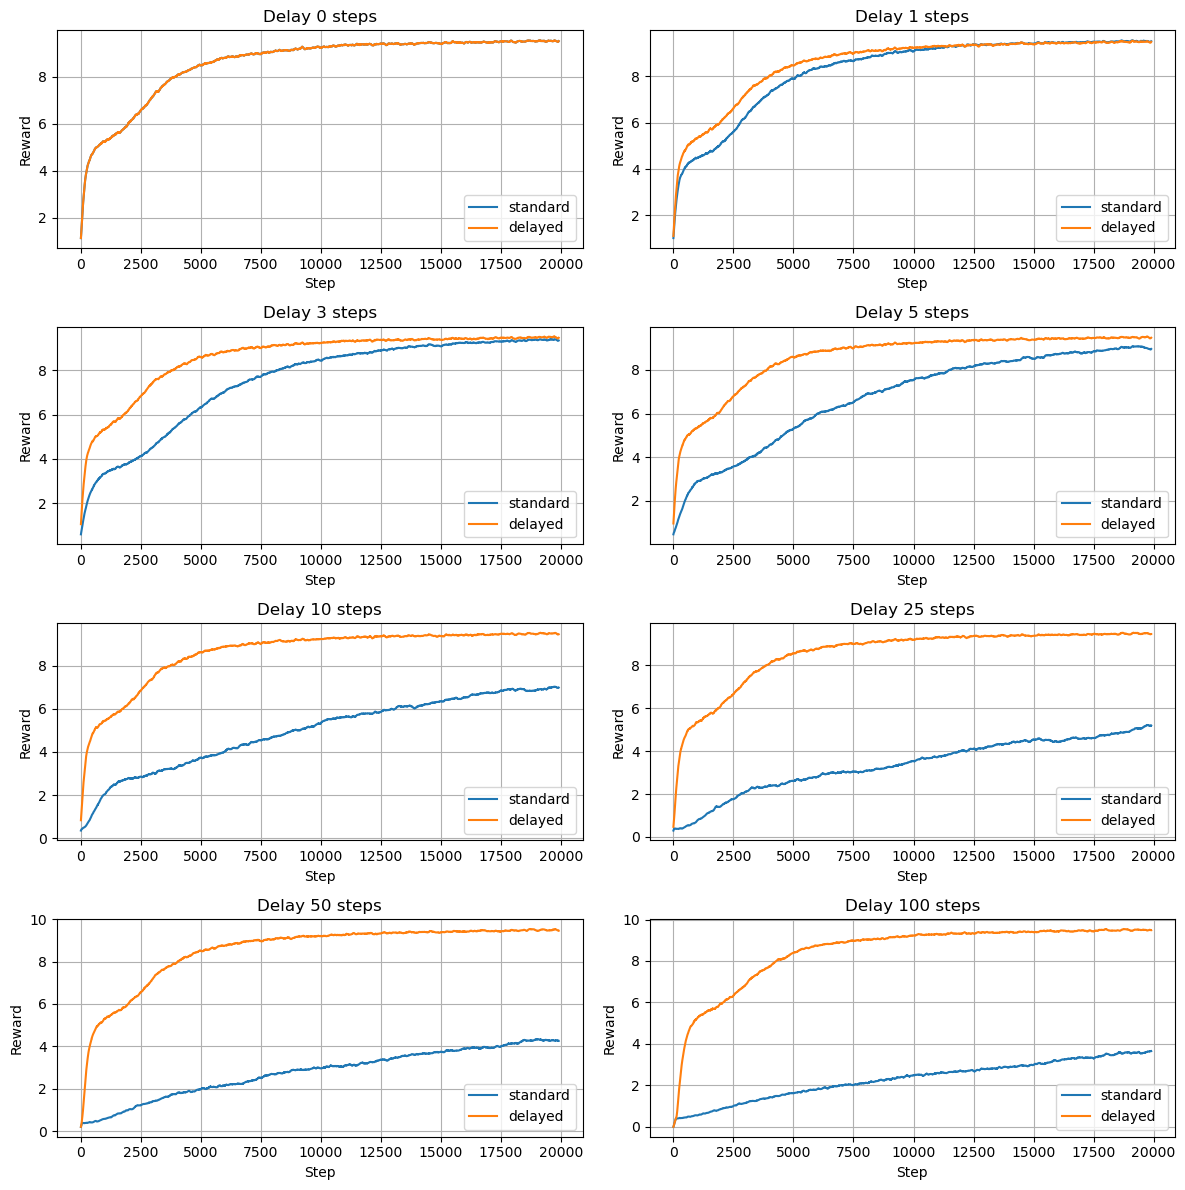

In [9]:
# plotter

import matplotlib.pyplot as plt
import pickle
import numpy as np

plt.figure(figsize=(12,12))

for i,delay in enumerate(delays):
    with open(f'pickles/rewards_d{delay}.pickle', 'rb') as file:
        rewards = pickle.load(file)
    with open(f'pickles/delayed_rewards_d{delay}.pickle', 'rb') as file:
        del_rewards = pickle.load(file)

    window = 100

    avg_over_episodes = np.mean(rewards, axis=0)
    moving_avg_over_steps = np.convolve(avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid' starts from step=window
    del_avg_over_episodes = np.mean(del_rewards, axis=0)
    del_moving_avg_over_steps = np.convolve(del_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid' starts from step=window

    plt.subplot(4,2,i+1)
    plt.title(f"Delay {delay} steps")
    plt.plot([i for i in range(len(moving_avg_over_steps))], 
             moving_avg_over_steps,
             label="standard")
    plt.plot([i for i in range(len(del_moving_avg_over_steps))],
             del_moving_avg_over_steps,
             label="delayed")
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.legend(loc='lower right')
    plt.grid()
plt.tight_layout()
plt.savefig('comparison.pdf')
plt.show()

In [10]:
# does it improve even with a rough estimate of the delay?

xdim = 5
ydim = 5
num_actions = 5
epsilon_0 = 3
learning_rate = 0.15
lamb = 0.9
gamma = 0.95
num_episodes = 1000
max_steps = 20_000

delay = 20
underestimated_delay = 15
overestimated_delay = 25

# Standard approach
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps)

storing_rewards = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    traces = np.zeros((xdim, ydim, num_actions))

    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(q[state])
    #
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        storing_rewards[episode, env.get_step()-1] = reward
        # replacing trace
        traces[(*state, action)] = 1
        #
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) #decaying exploration 
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(q[state_next])
        #
        # update q
        q = q + traces*learning_rate*(reward + gamma*q[(*state_next, action_next)] - q[(*state, action)])
        #
        # replacing trace
        traces *= lamb*gamma
        #
        state = state_next
        action = action_next


# DELAYED TRACES (perfect delay information)
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps)

del_storing_rewards = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    del_q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    del_traces = np.zeros((xdim, ydim, num_actions))

    state_buffer = deque()
    action_buffer = deque()
    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(del_q[state])
    #
    state_buffer.append(state)
    action_buffer.append(action)
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        del_storing_rewards[episode, env.get_step()-1] = reward
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(del_q[state_next])
        #
        state_buffer.append(state_next)
        action_buffer.append(action_next)
        if env.get_step() > delay:
            state_delayed = state_buffer.popleft()
            action_delayed = action_buffer.popleft()
            state_next_delayed = state_buffer[0]
            action_next_delayed = action_buffer[0]
            # replacing trace
            del_traces[(*state_delayed, action_delayed)] = 1
            #
            # update q
            del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                          del_q[(*state_delayed, action_delayed)])
            #
            # replacing trace
            del_traces *= lamb*gamma
            #
        state = state_next
        action = action_next
        
        
# DELAYED TRACES (unestimated delay information)
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps) # the delay in the environment is the true delay

del_storing_rewards_under = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    del_q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    del_traces = np.zeros((xdim, ydim, num_actions))

    state_buffer = deque()
    action_buffer = deque()
    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(del_q[state])
    #
    state_buffer.append(state)
    action_buffer.append(action)
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        del_storing_rewards_under[episode, env.get_step()-1] = reward
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(del_q[state_next])
        #
        state_buffer.append(state_next)
        action_buffer.append(action_next)
        if env.get_step() > underestimated_delay: # the update is done based on the inexact delay
            state_delayed = state_buffer.popleft()
            action_delayed = action_buffer.popleft()
            state_next_delayed = state_buffer[0]
            action_next_delayed = action_buffer[0]
            # replacing trace
            del_traces[(*state_delayed, action_delayed)] = 1
            #
            # update q
            del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                          del_q[(*state_delayed, action_delayed)])
            #
            # replacing trace
            del_traces *= lamb*gamma
            #
        state = state_next
        action = action_next
        

# DELAYED TRACES (overestimated delay information)
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps) # the delay in the environment is the true delay

del_storing_rewards_over = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    del_q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    del_traces = np.zeros((xdim, ydim, num_actions))

    state_buffer = deque()
    action_buffer = deque()
    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(del_q[state])
    #
    state_buffer.append(state)
    action_buffer.append(action)
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        del_storing_rewards_over[episode, env.get_step()-1] = reward
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(del_q[state_next])
        #
        state_buffer.append(state_next)
        action_buffer.append(action_next)
        if env.get_step() > overestimated_delay: # the update is done based on the inexact delay
            state_delayed = state_buffer.popleft()
            action_delayed = action_buffer.popleft()
            state_next_delayed = state_buffer[0]
            action_next_delayed = action_buffer[0]
            # replacing trace
            del_traces[(*state_delayed, action_delayed)] = 1
            #
            # update q
            del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                          del_q[(*state_delayed, action_delayed)])
            #
            # replacing trace
            del_traces *= lamb*gamma
            #
        state = state_next
        action = action_next

# Storing
with open(f'pickles/rewards_d{delay}.pickle', 'wb') as door:
    pickle.dump(storing_rewards, door)
with open(f'pickles/delayed_rewards_d{delay}.pickle', 'wb') as door2:
    pickle.dump(del_storing_rewards, door2)
with open(f'pickles/delayed_rewards_d{delay}_under.pickle', 'wb') as door3:
    pickle.dump(del_storing_rewards_under, door3)
with open(f'pickles/delayed_rewards_d{delay}_over.pickle', 'wb') as door4:
    pickle.dump(del_storing_rewards_over, door4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:25<00:00,  4.87it/s]


In [12]:
### just getting information about other cases of wrong delayed estimation
### all of these tests should just be functionalized, I'm just lazy copy-pasting for now


# DELAYED TRACES (unestimated delay information)
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps) # the delay in the environment is the true delay

del_storing_rewards_under = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    del_q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    del_traces = np.zeros((xdim, ydim, num_actions))

    state_buffer = deque()
    action_buffer = deque()
    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(del_q[state])
    #
    state_buffer.append(state)
    action_buffer.append(action)
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        del_storing_rewards_under[episode, env.get_step()-1] = reward
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(del_q[state_next])
        #
        state_buffer.append(state_next)
        action_buffer.append(action_next)
        if env.get_step() > delay - 2: # the update is done based on the inexact delay
            state_delayed = state_buffer.popleft()
            action_delayed = action_buffer.popleft()
            state_next_delayed = state_buffer[0]
            action_next_delayed = action_buffer[0]
            # replacing trace
            del_traces[(*state_delayed, action_delayed)] = 1
            #
            # update q
            del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                          del_q[(*state_delayed, action_delayed)])
            #
            # replacing trace
            del_traces *= lamb*gamma
            #
        state = state_next
        action = action_next
        

# DELAYED TRACES (overestimated delay information)
seed = 42
np.random.seed(seed)
env = Grid(xdim, ydim,delay=delay,max_steps=max_steps) # the delay in the environment is the true delay

del_storing_rewards_over = np.empty((num_episodes, env.get_max_steps()))
for episode in trange(num_episodes):
    del_q = np.zeros((xdim, ydim, num_actions))
    for x in range(xdim):
        for y in range(ydim):
            del_q[x, y] = [np.random.uniform(0, 1) for i in range(num_actions)]  # induce exploration
    del_traces = np.zeros((xdim, ydim, num_actions))

    state_buffer = deque()
    action_buffer = deque()
    state = env.reset()
    # eps-greedy action
    epsilon = epsilon_0
    draw = np.random.uniform(0, 1)
    if draw < epsilon:
        action = np.random.randint(num_actions)
    else:
        action = np.argmax(del_q[state])
    #
    state_buffer.append(state)
    action_buffer.append(action)
    done = False
    while not done:
        state_next, reward, done = env.step(action)
        del_storing_rewards_over[episode, env.get_step()-1] = reward
        # eps-greedy action
        epsilon = epsilon_0/(np.sqrt(env.get_step())+1) # decaying exploration
        draw = np.random.uniform(0, 1)
        if draw < epsilon:
            action_next = np.random.randint(num_actions)
        else:
            action_next = np.argmax(del_q[state_next])
        #
        state_buffer.append(state_next)
        action_buffer.append(action_next)
        if env.get_step() > delay + 2: # the update is done based on the inexact delay
            state_delayed = state_buffer.popleft()
            action_delayed = action_buffer.popleft()
            state_next_delayed = state_buffer[0]
            action_next_delayed = action_buffer[0]
            # replacing trace
            del_traces[(*state_delayed, action_delayed)] = 1
            #
            # update q
            del_q = del_q + del_traces*learning_rate*(reward + gamma*del_q[(*state_next_delayed, action_next_delayed)] -
                                          del_q[(*state_delayed, action_delayed)])
            #
            # replacing trace
            del_traces *= lamb*gamma
            #
        state = state_next
        action = action_next

# Storing
with open(f'pickles/delayed_rewards_d{delay}_under2.pickle', 'wb') as door:
    pickle.dump(del_storing_rewards_under, door)
with open(f'pickles/delayed_rewards_d{delay}_over2.pickle', 'wb') as door2:
    pickle.dump(del_storing_rewards_over, door2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:31<00:00,  4.72it/s]


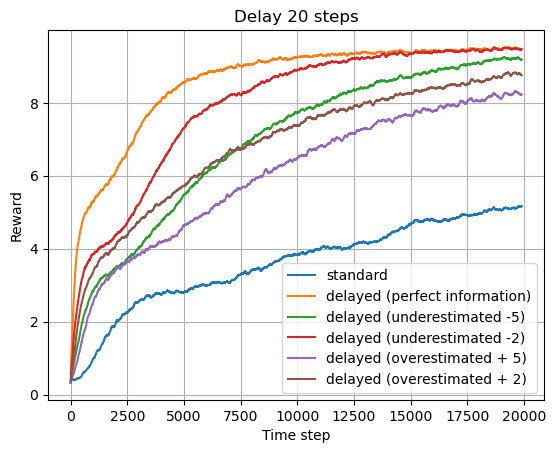

In [14]:
with open(f'pickles/rewards_d{delay}.pickle', 'rb') as file:
    rewards = pickle.load(file)
with open(f'pickles/delayed_rewards_d{delay}.pickle', 'rb') as file:
    del_rewards = pickle.load(file)
with open(f'pickles/delayed_rewards_d{delay}_under.pickle', 'rb') as file:
    del_rewards_under5 = pickle.load(file)
with open(f'pickles/delayed_rewards_d{delay}_over.pickle', 'rb') as file:
    del_rewards_over5 = pickle.load(file)
with open(f'pickles/delayed_rewards_d{delay}_under2.pickle', 'rb') as file:
    del_rewards_under2 = pickle.load(file)
with open(f'pickles/delayed_rewards_d{delay}_over2.pickle', 'rb') as file:
    del_rewards_over2 = pickle.load(file)

window = 100

avg_over_episodes = np.mean(rewards, axis=0)
moving_avg_over_steps = np.convolve(avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid' starts from step=window
del_avg_over_episodes = np.mean(del_rewards, axis=0)
del_moving_avg_over_steps = np.convolve(del_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid'starts from step=window
del_under5_avg_over_episodes = np.mean(del_rewards_under5, axis=0)
del_under5_moving_avg_over_steps = np.convolve(del_under5_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid'starts from step=window
del_over5_avg_over_episodes = np.mean(del_rewards_over5, axis=0)
del_over5_moving_avg_over_steps = np.convolve(del_over5_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid'starts from step=window
del_under2_avg_over_episodes = np.mean(del_rewards_under2, axis=0)
del_under2_moving_avg_over_steps = np.convolve(del_under2_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid'starts from step=window
del_over2_avg_over_episodes = np.mean(del_rewards_over2, axis=0)
del_over2_moving_avg_over_steps = np.convolve(del_over2_avg_over_episodes, np.ones(window)/window, mode='valid')  # with 'valid'starts from step=window


plt.title(f"Delay {delay} steps")
plt.plot([i for i in range(len(moving_avg_over_steps))], 
         moving_avg_over_steps,
         label="standard")
plt.plot([i for i in range(len(del_moving_avg_over_steps))],
         del_moving_avg_over_steps,
         label="delayed (perfect information)")
plt.plot([i for i in range(len(del_under5_moving_avg_over_steps))],
         del_under5_moving_avg_over_steps,
         label="delayed (underestimated -5)")
plt.plot([i for i in range(len(del_under2_moving_avg_over_steps))],
         del_under2_moving_avg_over_steps,
         label="delayed (underestimated -2)")
plt.plot([i for i in range(len(del_over5_moving_avg_over_steps))],
         del_over5_moving_avg_over_steps,
         label="delayed (overestimated + 5)")
plt.plot([i for i in range(len(del_over2_moving_avg_over_steps))],
         del_over2_moving_avg_over_steps,
         label="delayed (overestimated + 2)")


plt.xlabel('Time step')
plt.ylabel('Reward')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Observation: it seems that underestimating the delay in rewards is way better than overestimating it.
Intuitively this make sense because, when overestimating, the reward "due" to a (s,a) is not attributed at all to it, while underestimating it is (although not with the full trace, as in perfect information).